This notebook to test the results of a trained segmentation model. This notebook will apply the segmentation model to any GLIMS_ID and produce a list of segmentations.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import read
import preprocess
import landsat_bands
import matplotlib.pyplot as plt
import rasterio
from skimage.filters import gaussian
from datetime import datetime
import cv2
import imageio.v2 as imageio
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from cnn import UNet, conv_block

import torchvision
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [2]:
#define inputs
glims_id = 'G007026E45991N' #trient

ts_output_dir = "time_series"
PROB_THRESH = 0.5

data_label = "full_time_series"
ee_data_dir = os.path.join(os.path.expanduser("~"),
    "PycharmProjects","glacier-view-analysis",  "src", "earth_engine","data","ee_landing_zone",data_label)
dem_data_dir = os.path.join(os.path.expanduser("~"),
    "PycharmProjects","glacier-view-analysis", "src", "earth_engine","data","ee_landing_zone","full_time_series")                         
landsat_dir = os.path.join(ee_data_dir, "landsat")
dem_dir = os.path.join(dem_data_dir, "dems")

glacier_dir = os.path.join(landsat_dir, glims_id)
dem_path = os.path.join(dem_dir, f"{glims_id}_NASADEM.tif")

In [3]:
common_bands = ['blue','green','red','nir','swir','thermal']
dim = (128,128)

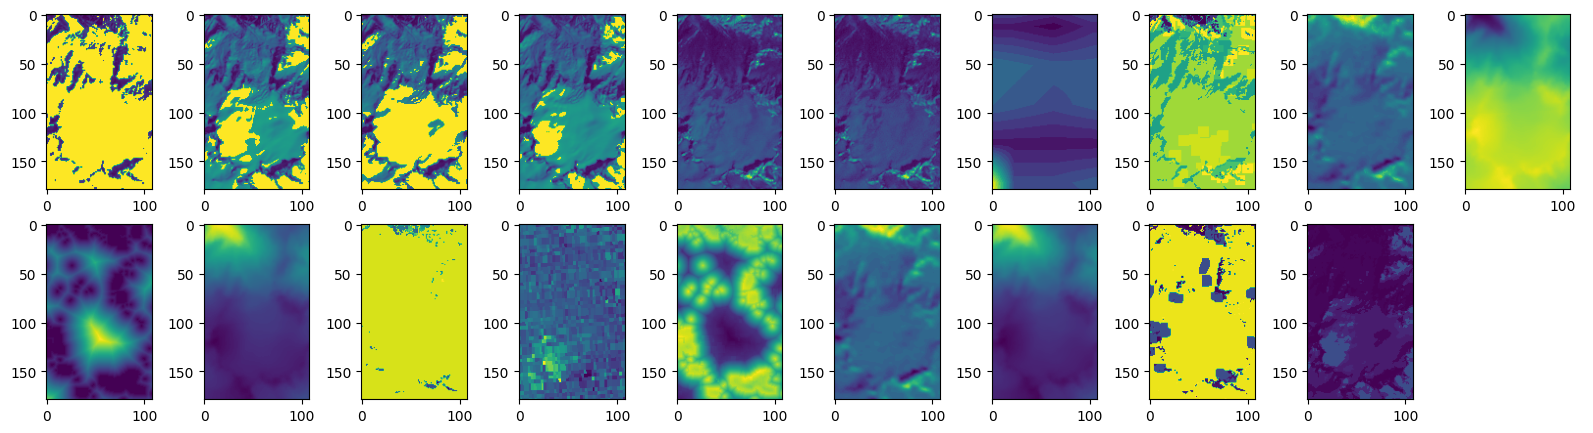

In [4]:
dataset = rasterio.open(glacier_dir+"/"+os.listdir(glacier_dir)[100]).read()

fig, axs = plt.subplots(nrows=2,ncols=10,figsize=(20, 5))
plt.axis('off')
for i in range(2):
    for j in range(10):
        if i==1 and j==9:
            pass
        else:
            axs[i,j].imshow(dataset[10*i+j])

plt.show()

In [5]:
images = read.get_rasters(glacier_dir)

In [6]:
#read and preprocess images
sample_image_key = list(images.keys())[0]
original_sizes = [images[sample_image_key].shape[:-1] for key in images.keys()]
print(f"Before preprocessipreprocess.get_common_bands(images,common_bands)ng single image shape: {images[sample_image_key].shape}")
nimages = preprocess.get_common_bands(images,common_bands)
nimages = preprocess.normalize_rasters(nimages)
nimages = preprocess.resize_rasters(nimages,dim)
print(f"After preprocessing single image shape: {nimages[sample_image_key].shape}")

Before preprocessipreprocess.get_common_bands(images,common_bands)ng single image shape: (177, 103, 19)
After preprocessing single image shape: (128, 128, 6)


C:\Users\somansh\anaconda3\envs\ml\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
len(nimages.keys())

464

In [8]:
#read and preprocess dems

dem = read.get_dem(dem_path)

dem_key = list(dem.keys())[0]
print(f"Before preprocessing single dem shape: {dem[dem_key].shape}")
dem = preprocess.resize_rasters(dem, dim)
dem = preprocess.normalize_rasters(dem)
print(f"After preprocessing single dem shape: {dem[dem_key].shape}")

Before preprocessing single dem shape: (174, 142, 1)
After preprocessing single dem shape: (128, 128, 1)


In [9]:
dem.keys()

dict_keys(['C:\\Users\\somansh\\PycharmProjects\\glacier-view-analysis\\src\\earth_engine\\data\\ee_landing_zone\\full_time_series\\dems\\G007026E45991N_NASADEM.tif'])

In [10]:
combined_images_and_dems = [np.concatenate((nimages[file_name], dem[dem_key]),axis = 2) for file_name in sorted(nimages.keys())]

In [11]:
#match images with labels
X = np.stack(combined_images_and_dems)
X = np.nan_to_num(X, copy=True, nan=0.0)

X_smoothed = gaussian(X, sigma = [20,0,0,0], mode = 'reflect')
image_file_names_ordered = sorted(nimages.keys())
image_dates = [datetime.strptime(f.split("_")[1],'%Y-%m-%d') for f in image_file_names_ordered]

In [12]:
torch_model = torch.load("model")
torch_model.to(device)
torch_model.eval()
pass

In [13]:
inputs = torch.tensor(X_smoothed)

inputs = inputs.permute(0,3,1,2)
SMOOTH_FACTOR = 0

green = inputs[:,1,:,:]
swir = inputs[:,4,:,:]
nir = inputs[:,3,:,:]

ndsi = (green - swir)/(green + swir+SMOOTH_FACTOR)
ndsi = ndsi.unsqueeze(dim=1)
inputs = torch.cat((ndsi, inputs), dim=1)

ndwi = (green - nir)/(green + nir+SMOOTH_FACTOR)
ndwi = ndwi.unsqueeze(dim=1)
inputs = torch.cat((ndwi, inputs), dim=1)

inputs.shape

torch.Size([464, 9, 128, 128])

In [14]:
prediction_dataset = TensorDataset(inputs) # create your datset
prediction_dataloader = DataLoader(prediction_dataset, batch_size=64,shuffle=False) # create your dataloader

In [15]:
predictions = []
for i in prediction_dataloader:
    with torch.no_grad():
        outputs = torch_model.forward(i[0].to(device=device,dtype=torch.float))
        outputs = torch.softmax(outputs, dim=1)
        outputs = outputs[:,1,:,:].unsqueeze(1)
    m = torch.nn.Threshold(PROB_THRESH, 0)
    predictions.append(m(outputs))
    
predictions = torch.cat(predictions, dim=0)

In [16]:
resized_predictions = []
area_per_pred = []
resized_imgs = []
for index, size in enumerate(original_sizes):
    resize = torchvision.transforms.Resize(size, antialias=True)
    pred = resize(predictions[index])
    resized_imgs.append(pred.detach().cpu().numpy()[0])
    area = pred.sum().detach().cpu().numpy()
    area = area*0.0009
    area_per_pred.append(area)
    resized_predictions.append(resize(predictions[index]))

In [17]:
import pandas as pd

df = pd.DataFrame(area_per_pred, image_dates)

df["G007026E45991N"] = df[0]
df.drop([0],axis=1)
df =  df["G007026E45991N"]
df = df.to_frame()
df.index.names = ['Dates']
df.to_csv("trient_areas.csv")

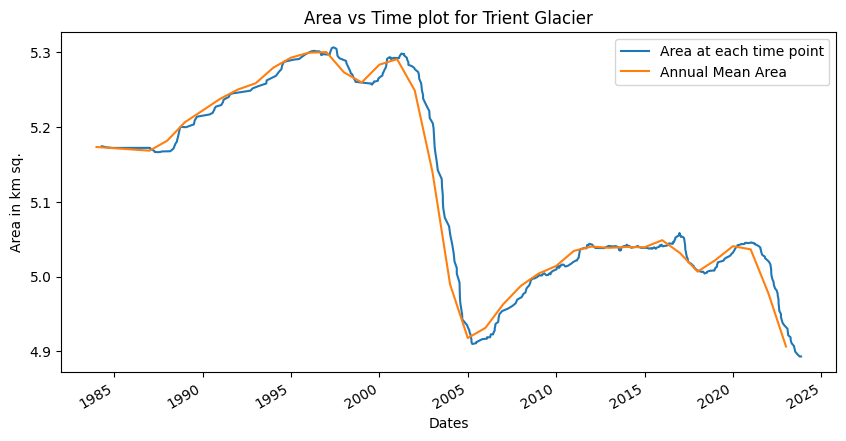

In [18]:
df.plot(figsize=(10,5), ylabel="Area in km sq.", xlabel="Years", title="Area vs Time plot for Trient Glacier")
mo = df.groupby(pd.PeriodIndex(df.index, freq="Y"))[df.columns[0]].mean()
mo.plot()
plt.legend(["Area at each time point","Annual Mean Area"])
plt.savefig(os.path.join(ts_output_dir, f"{glims_id}.png"))

In [19]:
img_keys = list(images.keys())

In [ ]:
#create GIF
predictions = predictions.detach().cpu().numpy()
gif_creation_dir = os.path.join(os.path.expanduser("~"), "PycharmProjects","glacier-view-analysis", "src", "segmentation","tmp","gif_creation")
gif_output_dir = os.path.join(os.path.expanduser("~"), "PycharmProjects","glacier-view-analysis", "src", "segmentation", "gifs")

for f in os.listdir(gif_creation_dir):
    os.remove(os.path.join(gif_creation_dir, f))

for i in range(X_smoothed.shape[0]):
    if i%1 == 0: #ignores 80% of images to run faster
        fig, axs = plt.subplots(2, figsize=(10,10)) ##update the number of suplots to equal the number of layers you want to display
        fig.suptitle(image_file_names_ordered[i])
        axs[0].imshow((X_smoothed[i,:,:,:][:,:,[2,1,0]]))
        # axs[0].imshow(predictions[i,0,:,:],alpha=0.1)
        axs[1].imshow((X_smoothed[i,:,:,:][:,:,[2,1,0]]))
        axs[1].imshow(predictions[i,0,:,:],alpha=0.2)

        plt.savefig(os.path.join(gif_creation_dir,f'{image_file_names_ordered[i]}_final.png'), dpi = 100)
        # plt.show()

with imageio.get_writer(os.path.join(gif_output_dir,f"{glims_id}_final.gif"), mode='I') as writer:
    for filename in sorted(os.listdir(gif_creation_dir)):
        image = imageio.imread(os.path.join(gif_creation_dir,filename))
        writer.append_data(image)
